<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/merge-utils/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a second test for an upcoming text book on computational neuroscience from an optimization/learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as a learning algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* **environment**, the (statistical) properties of where an organism lives
* **behaviour**, the statistics of what the organism does
* **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment

This very much is the core of why we are writing this book: we can view pretty much anything happening in the brain (and biology) as being part of a process that brings about improvement in this sense.

___
# Chapter 1.1 Behaviour as a Policy in an Environmental Context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals resulting from the organism's actions in the environment are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies as it becomes difficult to determine whether poor outcomes are due the policy itself or simply bad luck.

___
# **Sequence 1.1.2: Thinking of What Receptors and Muscles Do as a Policy**

### Objective: In this sequence, we will continue to use the Gridworld environment-organism system to see how behaviour can be abstracted as input --> compute --> output process, and how such processes can be formalized as a **policy** with **parameters**.

Picture showing receptor/input, brain/compute, musceles/output embedded in the environment feedback loop. (The following is a place holder for our actual image, but it's close to the right thing.)
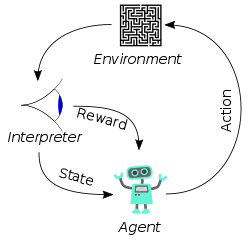

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py', 'gw_widgets.py',]
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/merge-utils/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C1_S2"

Random seed 2021 has been set.
Running in colab


# 1.1.2.1: Limited Perception (fog of war)

In the previous sequence you and the organism were effectively omniscient, i.e. had both complete and accurate knowledge of the state of the environment. This is also the case in games like go or chess where all relevant information is available. However, these scenarios of total knowledge are unusual, artificial exceptions. In contrast, most living organisms face a situation where the relevant state of the environment is perceived only in part and with uncertainty. To illustrate this, let's introduce a new organism, *Fishy*. Drawing inspiration from weakly electric fish (see for example the work of Malcolm MacIver), *Fishy*, can only perceive the 12 cells of the Gridworld immediately adjacent to it (those cells within a radius of 2 using $L_1$, or 'city block' distance). For now, *Fishy* aimlessly swims around on the grid. Let's see what that looks like.


In [2]:
# @title Random Movement with Limited Perception
# @markdown Don't worry about how this code works – just **run this cell** and press the start button to see what *Fishy's* limited field of perception looks like.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
random_igwg = InteractiveGridworld(gwg, has_fov=True, figsize=(5,4),
                                   critter_name='$\mathit{Fishy}$',
                                   player=None)
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.final_display)

Now that you've seen what this limited field of perception looks like it's time for a micro science question:

**Are *Fishy's* perceptions of the environment predictive of whether or not they will eat food?**

Make a guess. Think about how you would prove to yourself whether your guess is right. There are lots of ways to validate your guess; let's explore one of them right now. Our first step is to **observe** the behavior and **collect data**! Any way of validating your guess that purports to be science (in the modern sense) will start this way, with data. However, keep in mind, there are other approaches and modes of thinking out there. For example, a theorist or mathematician might bypass observations and data, diving straight into deductions based on abstract assumptions. But, that's not going to be our approach here and now (though we will borrow it occasionally throughout the book).

In [3]:
# @title Observations of Random Movement with Limited Perception
# @markdown Don't worry about how this code works – just **run this cell**, then press the start button and watch the data collection happen.
rng = np.random.default_rng(seed=2023)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
record_igwg = InteractiveGridworld(gwg, has_fov=True, collect_fov_data=True,
                                   player=None, critter_name='$\mathit{Fishy}$',
                                   figsize=(4,4))
display(record_igwg.b_fig.canvas)
display(record_igwg.b_fig_legend.canvas)
clear_output()
display(record_igwg.final_display)

Start by running two or three simulations to collect 'adequate' data for analysis.

**Thought/Bonus/Further Reading: How much data is truly 'enough'?:**

Entire methodologies have been developed to answer this critical question.  In a hypothesis testing framework, power analysis is used to determine optimal sample size by considering the strength an effect to be detected and the desired statistical power of the test. In an ML framework, notions of Empirical Risk Minimization inform the amount of data needed. In a Bayesian context, assessment of convergence of posterior distributions of parameters indicates whether incoming data is helping (or continues to help) improve those parameter estimates.


Now that we have some observations, let's put them in a structure we can easily work with. Here's how the data looks:

In [4]:
data = record_igwg.fov_eat_table_data
display(data)

array([[ 6., 10.,  5.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

When analyzing data we ***always*** plot the data before doing ***anything*** else. Which visualization to start with is a more subjective question, though histograms and scatter plots are often good starting points. In this case we'll go for a [histogram](## "In a histogram each bin represents a range of values, and the height of the bar shows the frequency (number of data points observed) within that range.") of the two distributions of number of food items perceived conditional on whether eating happened immediately afterward or not. Before you run the code below to generate the picture, think about what it might look like.

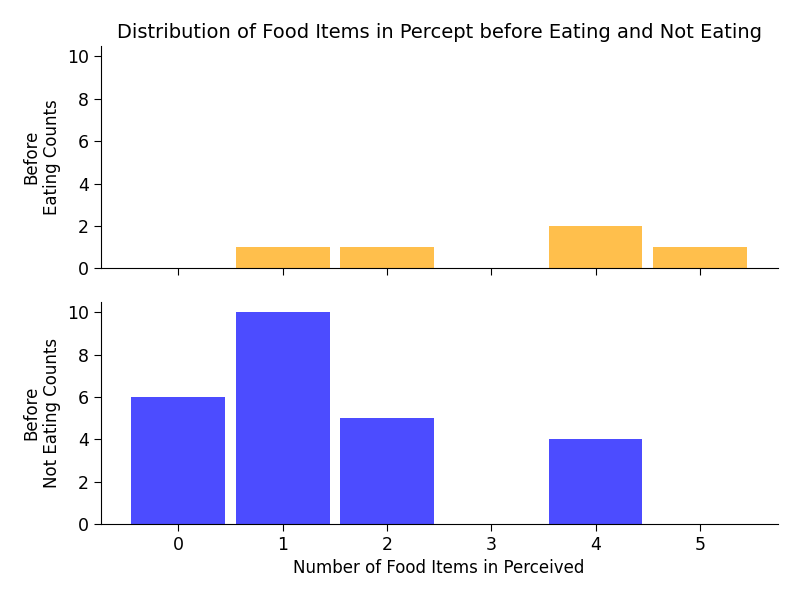

In [5]:
# If data collection step was skipped above use this data instead
if np.all(data == np.zeros(data.shape)):
  print("You haven't collected any data, using canned data instead.")
  data = np.array(
    [[10., 22., 11.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
     [ 0.,  1.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

# Unpack the contingency table into a list of raw observations
# A flat array of perception values before 'Not Eating' events
not_eating = np.repeat(range(len(data[0])), data[0].astype(int))
# A flat array of perception values before 'Eating' events
eating = np.repeat(range(len(data[0])), data[1].astype(int))

# Create histograms
fig_hist, (ax1_hist, ax2_hist) = plt.subplots(2, 1, sharex=True, sharey=True,
                                              figsize=(8,6))
# Define bin edges
nonzero_col_index = np.where(data > 0)[1]
bin_edges = np.arange(-0.5, np.max(nonzero_col_index) + 1.5, 1)
# Plot Histograms
ax2_hist.hist(not_eating, bins=bin_edges, color='blue', alpha=0.7, rwidth=0.9)
ax1_hist.hist(eating, bins=bin_edges, color='orange', alpha=0.7, rwidth=0.9)
ax1_hist.set_title('Distribution of Food Items in Percept before Eating and Not Eating',
                   fontsize=14)
ax1_hist.set_ylabel('Before\nEating Counts', fontsize=12)
ax2_hist.set_ylabel('Before\nNot Eating Counts', fontsize=12)
ax2_hist.set_xlabel('Number of Food Items in Perceived', fontsize=12)
remove_ip_clutter(fig_hist)
fig_hist.tight_layout()
plt.show()

These histograms reveal differences in the distribution of perceived food items immediately prior to 'Eating' and 'Not Eating' events. 'Not Eating' is more frequently observed, especially when fewer food items are perceived beforehand. This should not be surprising, fishy sees 12 spots, a small number of which typically carry food. On the other hand, 'Eating' events, although less common, tend to occur more often when more food items are perceived. These initial observations hint that the perception of food may be predictive of eating.

To get at our question — does perceiving food predict eating more directly? — we will next plot the proportion of times eating followed for the different numbers of food items perceived. Again, to visualize what the plot might look like before you run the following code.

In [6]:
################################################################################
# TODO for students: Replace ... in the line:
# prob_eating plot_data[...] / plot_data.sum(axis=...)
# Comment out or remove this next lines.
raise NotImplementedError("Exercise: plot proportion of eating")
################################################################################

# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[...] / plot_data.sum(axis=...)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
# Display the plot
plt.show()

NotImplementedError: ignored

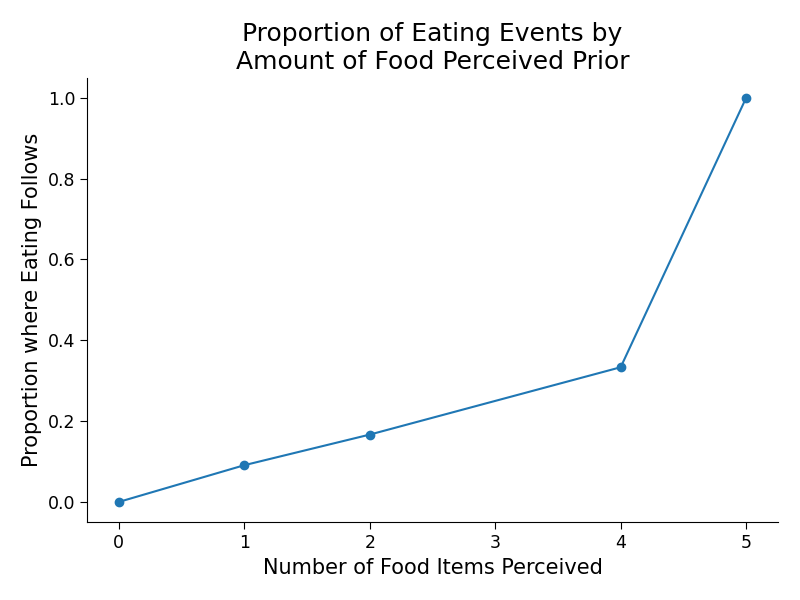

In [7]:
# to_remove solution
# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[1,:] / plot_data.sum(axis=0)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
fig_prop.tight_layout()
# Display the plot
plt.show()

In this plot, it appears that the proportion of eating events increases as the amount of food perceived immediately prior increases. This suggests that the amount of food perceived could indeed predict eating behavior. However, this is just a visualization and not a formal test of a causal relationship. Later in the book we will review how to formally assess predictiveness through statistical models, such as logistic regression, which would be suitable for this case of predicting a binary outcome (eating vs. not eating) from a predictor variable (or variables) like the amount of food perceived.

Bonus: Think about what makes a good predictor variable:

We observed and recorded the total number of food items percieved and used that as our 'predictor' variable in the analysis and visualizations above. Do you think there are other aspects of *Fishy's* perceptions, beyond just the total number of food items perceived that could be used to make better predictions about the amount of food eaten?(Hint: Could the predictor variable consider the relative location of food items within the perceptual field?) [Solution.](## "In terms of predicting immediate eating, really only the four grid cells immediately adjacent to *fishy* can have any bearing on whether eating will happen in the next round, so the sum of food items just in those four cells would be a much better predictor. Note that we haven't gotten into what 'better' means yet for a predictor so this question is kind of ill formed, but we will eventually and what makes a good predictor is good thing to start thinking about right away.")

In [8]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.1.2.2: Perception Guiding Actions is a Policy

We've seen that even in the case of random drifting, perceptions of the environment can carry information about import things like whether or not eating will happen. Now, we're going to hook this perceptive field up to some highly abstracted 'muscles' by making a simple set of rules that translate *Fishy's* perceptions into a choice of actions (one of up, down, left, right).

Before we attempt this we need to understand the form of *Fishy's* perceptions. We recorded some of these in the previous section, what do they look like?

In [9]:
# 'record_igwg' is an instance of an InteractiveGridworld object
# that we ran in the cell above to record data
print(f"Type of 'record_igwg': {type(record_igwg)}")

Type of 'record_igwg': <class '__main__.InteractiveGridworld'>


In [10]:
# 'record_igwg' has a 'percept_eat_records' attribute. This is a list of all
# the records from the games played by the InteractiveGridworld object since it
# was instantiated.
print(f"Type of 'percept_eat_records': {type(record_igwg.percept_eat_records)}")
# The length of 'percept_eat_records' should be 30 times the number of times you
# ran the simulation.
print(f"Length of 'percept_eat_records': {len(record_igwg.percept_eat_records)}")

Type of 'percept_eat_records': <class 'list'>
Length of 'percept_eat_records': 30


Now, let's inspect what a record looks like:

In [11]:
# If we didn't collect any data we'll use some canned data
if len(record_igwg.percept_eat_records) < 2:
  record_igwg.percept_eat_records.append(
    {'perception': np.array(
        [-1., -1.,  0., -2., -1.,  0., -2., -2., -1.,  0., -2.,  0.]),
     'state': {
      'pieces': np.array(
          [[[ 0.,  0.,  0., -1., -1.,  0., -1.],
            [ 0.,  0., -1.,  0., -1., -1.,  0.],
            [ 0.,  0.,  0.,  0., -1.,  0.,  1.],
            [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
            [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
            [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
            [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
      'scores': np.array([0.]),
      'rounds_left': np.array([30.])},
     'did_eat': False})
  record_igwg.percept_eat_records.append(
    {'perception': np.array(
        [ 0.,  0.,  0., -2.,  0., -1., -2., -2., -1.,  0., -2.,  0.]),
     'state': {
        'pieces': np.array(
            [[[ 0.,  0.,  0., -1., -1.,  0., -1.],
              [ 0.,  0., -1.,  0., -1., -1.,  0.],
              [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
        'scores': np.array([0.]),
        'rounds_left': np.array([29.])},
     'did_eat': False})

# Let's examine the first two elements of the list.
# What type is the record?
print(f"Type of first record: {type(record_igwg.percept_eat_records[0])}")
# What does the first one look like?
print('----------------------------------')
display(record_igwg.percept_eat_records[0])
# What does the second one look like?
print('----------------------------------')
display(record_igwg.percept_eat_records[1])

Type of first record: <class 'dict'>
----------------------------------


{'perception': array([-1., -1.,  0., -2., -1.,  0., -2., -2., -1.,  0., -2.,  0.]),
 'state': {'pieces': array([[[ 0.,  0.,  0., -1., -1.,  0., -1.],
          [ 0.,  0., -1.,  0., -1., -1.,  0.],
          [ 0.,  0.,  0.,  0., -1.,  0.,  1.],
          [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
  'scores': array([0.]),
  'rounds_left': array([30.])},
 'did_eat': False}

----------------------------------


{'perception': array([ 0.,  0.,  0., -2.,  0., -1., -2., -2., -1.,  0., -2.,  0.]),
 'state': {'pieces': array([[[ 0.,  0.,  0., -1., -1.,  0., -1.],
          [ 0.,  0., -1.,  0., -1., -1.,  0.],
          [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
  'scores': array([0.]),
  'rounds_left': array([29.])},
 'did_eat': False}

It looks like the first two elements of the list are dictionaries, and, as it turns out, all elements share this structure. These dictionaries contain relatively self-descriptive keys. Let's walk through the structure of these records element by element.

* `perception`: This is a 12-element array with -2's denoting areas where the perceptual field lies outside the boundaries of the Gridworld, 0's indicating empty spaces on the grid, and -1's marking food locations.
* `state`: This is another dictionary representing the state of the board at the time of the perception. The `pieces` element of `state` is a 7x7 array depicting the grid positions of the organism (1), the food (-1's), and the empty spaces (0's). The `scores` and `rounds_left` elements describe exactly what their names suggest.
* `did_eat`: This is a boolean indicator that is `True` when eating occurred in the round immediately following the perception and `False` when eating did not occur.

Can you see how the perceptive field, as defined below, is overlaid on the 7x7 array to generate a perceptions?

In [12]:
# define the L1 ball mask the determines what an organism perceives
# Perception radius for an organism
radius = 2
# Grid size to encompass perception 'circle', include center point
diameter = radius*2+1
# Empty grid (initially all False)
mask = np.zeros((diameter, diameter), dtype=bool)
# Relative coordinates for grid points, center at (0,0)
mask_coords = np.array([(i-radius, j-radius)
  for i in range(diameter)
  for j in range(diameter)])
# Calculate cityblock distance from each point to center
mask_distances = cdist(mask_coords, [[0, 0]], 'cityblock').reshape(mask.shape)
# Mark points within perception radius as True
mask[mask_distances <= radius] = True
# Exclude center point (organism itself)
mask[radius,radius] = False
print('--------------------Perceptive Field---------------------------')
display(mask)
print('\n--------------------Environment-------------------------------')
display(record_igwg.percept_eat_records[0]['state']['pieces'])
print('\n--------------------Perception--------------------------------')
display(record_igwg.percept_eat_records[0]['perception'])

--------------------Perceptive Field---------------------------


array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True, False,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]])


--------------------Environment-------------------------------


array([[[ 0.,  0.,  0., -1., -1.,  0., -1.],
        [ 0.,  0., -1.,  0., -1., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]])


--------------------Perception--------------------------------


array([-1., -1.,  0., -2., -1.,  0., -2., -2., -1.,  0., -2.,  0.])

The indices of the perception array correspond to the spaces around the organism as follows.

In [13]:
numbered_mask = np.ones(mask.shape) * -1
numbered_mask[mask] = range(mask.sum())
display(numbered_mask)

array([[-1., -1.,  0., -1., -1.],
       [-1.,  1.,  2.,  3., -1.],
       [ 4.,  5., -1.,  6.,  7.],
       [-1.,  8.,  9., 10., -1.],
       [-1., -1., 11., -1., -1.]])

Note that Fishy lacks an orientation in relation to the Gridworld; all directions are defined in absolute or cardinal terms: 'up', 'down', 'left', and 'right'. So another way of thinking about the perception vector is as follows:

In [14]:
# in human readable terms the perception is organized as
human_readable_percept_structure = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
print(human_readable_percept_structure)

['far up', 'left up', 'near up', 'right up', 'far left', 'near left', 'near right', 'far right', 'left down', 'near down', 'right down', 'far down']


Now that we understand what a perception looks like, let's build a function that accepts a perception as input and outputs one of four possible moves. To start, we'll create a simple function based on the following logic: if any is food immediately adjecent, *Fishy* moves towards it; otherwise *Fishy* moves randomly.


In [15]:
# @markdown Run this cell to set up the tests for the code exercise below
def test_action_from_perception(test_func):
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']

  # Test when there's no food nearby
  perception = np.zeros(12)
  assert test_func(perception) in ['up', 'down', 'left', 'right']

  # Test when there's food to the near up
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  assert test_func(perception) == 'up'

  # Test when there's food to the near down
  perception = np.zeros(12)
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) == 'down'

  # Test when there's food to the near left
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  assert test_func(perception) == 'left'

  # Test when there's food to the near right
  perception = np.zeros(12)
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) == 'right'

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) in ['up', 'right']

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) in ['down', 'left']

  print('Congrats, Tests Passed')

In [16]:
################################################################################
# TODO for students: Complete the lines with ...  to identify directions where
# food is nearby and then randomly choose between directions with nearby food
# if food is nearby. Then comment out the line below and see if your code
# runs and passes the code checks.
raise NotImplementedError("Exercise: make actions depend on perception")
################################################################################


# to_remove solution
def simple_action_from_percept(percept, rng=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == ...]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return rng.choice(...)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return rng.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

NotImplementedError: ignored

In [17]:
# to_remove solution
def simple_action_from_percept(percept, rng=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == -1]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return rng.choice(food_directions)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return rng.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

Congrats, Tests Passed


Congratulations, you've just implemented your first policy function. Any  function, like this one, that takes perceptions as inputs and outputs actions, in the context of an environmental feedback loop is called a ***policy***.

Also, observe how we use a test here to check if your code does the right things. When writing good, high quality, code, most programmers write such tests for their own code. Writing more lines for the tests than the code being tested is perfectly standard. The number, breadth, and quality of the tests is what ultimately defines how much you can trust your code!

Now that we have a policy let's see how it compares to random drifting.

In [18]:
# @title A Simple Rule Based Policy Versus Random Drifting
# @markdown Don't worry about how this code works – just **run the cell** and press start to compare the policy we defined above with random drifting.

class SimpleRulePlayer():
  """
  A Player based on the following simple policy:
  If there is any food immediately nearby move towards it,
  otherwise it move randomly.
  """

  def __init__(self, game, fov_radius=2):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
    Returns:
      Nothing
    """
    self.game = game
    self.fov_radius = fov_radius


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indeces of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape

    #get the percept for every board in the batch
    perceptions = self.game.get_perceptions(board, self.fov_radius)
    critter_oriented_moves = []
    for g in range(batch_size):
      critter_oriented_moves.append(
          simple_action_from_percept(perceptions[g], self.game.rng))
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, a_1hots


# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
srp = SimpleRulePlayer(gwg)
h2h_igwg = Head2HeadGridworld(gwg, player0=None, p0_short_name='RANDOM',
                              p0_long_name='Random\nPolicy',
                              player1=srp, p1_short_name='EAT_NEAR',
                              p1_long_name='Eat Nearby\nPolicy',
                              figsize=(2.4,3.0), has_fov=True, radius=2,
                              critter_name='$\mathit{Fishy}$')
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

Okay, hopefully we've implemented our rule correctly and we shouldn't be surprised to see that moving towards food when it is nearby (usually) results in much more eating than just drifting around randomly. In a patchy environment like this - food is in some places but not others - contingent action is a big advantage. However, as you may have noticed, *Fishy* is not taking full advantage of its perceptual field. There is perceived food (not immediately adjacent) that *Fishy* could move closer towards, but right now *Fishy* only acts on perceptions of food immediately adjacent. Next we're going to see if we can make *Fishy* an even more efficient eater by utilizing the whole perceptive field when choosing a movement direction.

In [19]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.1.2.3: Parameterization of a Policy

Our first policy function could be neatly summarized as "If there is food immediately adjecent, move towards it, otherwise move randomly." It was not too difficult to translate this simple rule into a concrete function of *Fishy's* perceptions. However, as the number of inputs increase, formulating an efficient rule in natural language and translating that rule into a function becomes increasingly challenging. An effective rule in natural language would need to identify all possible food configurations, group them into cases, and then assign an appropriate direction to each case. It's a feasible approach, but very labour intensive. So, instead we are going to expand our way of thinking about policies to include [parameterization.](## "In general the distinction between the parameters and the variables of a function is not always clear cut and is often dependent on the context. In this book, in the context of a policy function, variables will primarily be the sensory/environmental inputs to a policy funtion and parameters will be internal values of an organism which change not as a result of the sensory/environmental context but as a result changes to the organism's internal state as a response to learning and/or evolutionary processes. Even here though the distinction if blurred when considering how memories of recent sensory events are incorporated into a policy function.")

Another reason to parameterize our policy function, and the motivation for our specific manner parameterization, is to align our policy function implementation slightly towards how neurons in an organism might implement a policy. Specifically, we want to start to think of the strengths of synaptic connections between neurons as a kind of parameter in a neural implementation of a function. For this, let's imagine a simplified 'cartoon' nervous system where each cell in the perceptual field represents a single neuron. These neurons send a signal when food is present in their corresponding section of the perceptual field and remain 'quiet' otherwise.

We then imagine that the organism has 4 "direction neurons" (up, down, left, and right) and that the relative firing strenghts of these direction neurons determine a probability distribution over the organism's movement direction. In this 'cartoon' nervous system, each neuron in the perceptual field connects to the dendrites of the direction neurons via an axon, with the connection strength determined by a parameterized weight. The firing strengths of the direction neurons are simply the sums of the weighted inputs they receive from the perceptual cells.

While this 'cartoon' is laughably far removed from how motor control is implemented in most animals, it is still a step closer to real neural computation compared to our initial rule based policy implementation. And, for a few very simple organisms this cartoon isn't so far from reality.


In mathematical terms this looks like having $\mathbf{W} \in \mathbb{R}^{4 \times 12}$ as the weight matrix with $4$ rows and $12$ columns represent the connection strength *weights* between the $12$ perception neurons and the $4$ muscle neurons, and having $\mathbf{x} \in \{0,1\}^{12}$ as a $12$-dimensional binary column vector represent the organism's perceptive field neuron activity.

The *activation* strengths of the muscle neurons, represented as $\mathbf{a} \in \mathbb{R}^4$, are then computed as the matrix-vector product $\mathbf{Wx}$, that is:

$$\mathbf{a} = \mathbf{Wx}$$

Each element $a_i$ of $\mathbf{a}$ is computed as:

$$a_i = \sum_{j=1}^{12} W_{ij}x_j$$

The matrix-vector product involves taking the dot product of the $i$-th row of $\mathbf{W}$ with the vector $\mathbf{x}$ to yield the $i$-th element of $\mathbf{a}$.

We perform this operation for each row $i$ (where $i$ ranges from $1$ to $4$) of the weight matrix $\mathbf{W}$ to obtain the complete activation vector $\mathbf{a}$.

To help make all this a little more concrete let's see what our first rule based policy would look like if it were structured in this parameterized way. We'll start by building a weight matrix.

In [20]:
# a human interpretable overview of the percept structure
percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
output_struct = ['up', 'down', 'left', 'right']

# a more explicit human legible way to set W
W1 = np.zeros((len(output_struct), len(percept_struct)))
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if input == 'near up':
      if output == 'up':
        W1[i,j] = 1
    elif input == 'near left':
      if output == 'left':
        W1[i,j] = 1
    elif input == 'near right':
      if output == 'right':
        W1[i,j] = 1
    elif input == 'near down':
      if output == 'down':
        W1[i,j] = 1

# slick programmer way to set W
W2 = np.zeros((len(output_struct), len(percept_struct)))
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if output in input:
      # *in* is a base python function that checks for containment. In this
      # case it checks if the ouput string is contained in the input string.
      # If output='up' and input='far up' output in input will evaluate as True
      # but if the input were 'near down' it would evaluate as false. Note that
      # this approach would fail terribly if our word for up were contained in
      # our word for down, i.e. if instead using 'down' we'd used the string
      # 'anti-up'. In general string based logic is fragile and bug prone,
      # but also can make code very human readabile. It's all trade-offs out
      # there be careful.
      if 'near' in input:
        W2[i,j] = 1

display(W1)
print('--------------------------------------------------------------')
display(W2)
assert(np.all(W1 == W2))
W = W1

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

--------------------------------------------------------------


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Next we'll use those weights to re-implement our first rule based function, and use our test from before to be sure we've done it right! Tests are ***so*** useful.

In [21]:
################################################################################
# TODO for students: Complete the lines output_activations = ... Then comment
# out the line below and see if your code runs and passes the same code checks
# we applied to our first rule based policy.
raise NotImplementedError("Exercise: parameterize a simple policy")
################################################################################


def parameterized_policy(percept, rng=None, W=W, softmax_temp=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
    W: a 4 x 12 weight matrix parameter representing the connection strenghts
      between the 12 perceptions inputs and the 4 possible output actions.

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  if softmax_temp is None:
    # very low temp, basically deterministic for this range of values
    softmax_temp = 0.01
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
  output_struct = ['up', 'down', 'left', 'right']
  # boolean representation of percept, no edges, just 1's where food is
  # zero otherwise
  x = np.asarray(percept == -1, int)
  # hint: Look at the equations above, the matrix-vector product (and it's
  # higher dimension generalizations) are implemented by the @ operator for
  # numpy arrays.
  output_activations = ...
  if np.sum(output_activations > 0):
    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp precision issues
    # probs below is a naive way to get a discrete probability distribution
    # from a real valued vector, why did we use softmax normalization instead?
    # probs = output_activations / np.sum(output_activations)
    action = rng.choice(output_struct, p=probs_sm)
  else:
    action = rng.choice(output_struct)
  return action

test_action_from_perception(parameterized_policy)

NotImplementedError: ignored

In [22]:
#to_remove solution


def parameterized_policy(percept, rng=None, W=W, softmax_temp=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
    W: a 4 x 12 weight matrix parameter representing the connection strenghts
      between the 12 perceptions inputs and the 4 possible output actions.

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  if softmax_temp is None:
    # very low temp, basically deterministic for this range of values
    softmax_temp = 0.01
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
  output_struct = ['up', 'down', 'left', 'right']
  # boolean representation of percept, no edges, just 1's where food is
  # zero otherwise
  x = np.asarray(percept == -1, int)
  # hint: Look at the equations above, the matrix-vector product (and it's
  # higher dimension generalizations) are implemented by the @ operator for
  # numpy arrays.
  output_activations = W @ x
  if np.sum(output_activations > 0):
    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp precision issues
    # probs below is a naive way to get a discrete probability distribution
    # from a real valued vector, why did we use softmax normalization instead?
    # probs = output_activations / np.sum(output_activations)
    action = rng.choice(output_struct, p=probs_sm)
  else:
    action = rng.choice(output_struct)
  return action

test_action_from_perception(parameterized_policy)

Congrats, Tests Passed


Okay, now it's your turn to make a really great *Fishy*. You can do this either by manually setting the weights below, or extending the weight setting logic used above to set W programatically, whichever seems less tedious to you.

In [23]:
################################################################################
# TODO for students: Fill in the values of the weight matrix below to define
# a really great parameterized policy for fishy. Then comment out the line
# below and see how your parameterized policy compares to the eat when nearby
# policy.
raise NotImplementedError("Exercise: pick good parameter values for W")
################################################################################

W_student = np.array(
     # input                                             # output
     #[fu, lu, nu, ru, fl, nl, nr, fr, ld, nd, rd, fd]   #
    [[  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # up
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # down
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # left
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]) # right

# comment out these nested for loops if you don't want use them to set the W
# W values and you'd rather just enter them manually above
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if input == ... :
      W_student[i,j] = ...
    elif ... :
      W_student[i,j] = ...
    # more elif logic here maybe


display(W_student)

NotImplementedError: ignored

In [24]:
# to_remove solution

W_student = np.array(
     # input                                             # output
     #[fu, lu, nu, ru, fl, nl, nr, fr, ld, nd, rd, fd]   #
    [[  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # up
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # down
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # left
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]) # right

# comment out these nested for loops if you don't want use them to set the W
# W values and you'd rather just enter them manually above
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if input == 'near ' + output:
      W_student[i,j] = 4.0
    elif output in input:
      W_student[i,j] = 1.0
    # more elif logic here maybe


display(W_student)

array([[1, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1],
       [0, 1, 0, 0, 1, 4, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 4, 1, 0, 0, 1, 0]])

In [25]:
# @title Your Parameterized Policy Versus the Simple Rule Based Policy
# @markdown Don't worry about how this code works – just **run the cell** and press start to compare the parameterized policy you've just defined to our simple rule based policy from before.

class ParamPlayer():
  """
  A Player playing a parameterized policy using the weights defined by the
  student in W_student.
  """

  def __init__(self, game, weights=None, fov_radius=2, ):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
    Returns:
      Nothing
    """
    self.game = game
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05

  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indeces of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape

    if temp is None:
      temp = self.default_softmax_temp

    #get the percept for every board in the batch
    perceptions = self.game.get_perceptions(board, self.fov_radius)
    critter_oriented_moves = []
    for g in range(batch_size):
      critter_oriented_moves.append(
          parameterized_policy(perceptions[g], self.game.rng, self.W, temp))
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, a_1hots


# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))

srp = SimpleRulePlayer(gwg)
spp = ParamPlayer(gwg, W_student) #student parameterized player
h2h_igwg2 = Head2HeadGridworld(gwg, player0=spp, p0_short_name='PARAMS',
                               p0_long_name='Parameterized\nPolicy',
                               player1=srp, p1_short_name='EAT_NEAR',
                               p1_long_name='Eat Nearby\nPolicy',
                               figsize=(2.4,3), has_fov=True, radius=2,
                               critter_name='$\mathit{Fishy}$')
display(h2h_igwg2.b_fig0.canvas)
display(h2h_igwg2.b_fig1.canvas)
display(h2h_igwg2.b_fig_legend.canvas)
clear_output()
display(h2h_igwg2.final_display)

Hopefully, by taking advantage of the full perceptive field, your parameterized policy able to outperform the simple 'Eat Nearby' policy. How good can a parameterized policy of this form be, and would the best policy be deterministic or probabalistic. We're not going to answer either of those directly now (though we will later). Instead we will explore how a parameter called 'temperature' can be used to control the level of randomness in a policy. As we will see later this randomness level will play a crucial role in answering these questions.

The following code snippet (slightly adapted) appeared in the previous coding exercise. Let's take a look at it now.

In [26]:
# Define the necessary inputs and context
rng = np.random.default_rng()  # Random number generator
output_activations = rng.random(4) * 5  # An example output activations array
softmax_temp = 1  # An example softmax temperature value
output_struct = ['up', 'down', 'left', 'right']  # Output structure

#compute softmax probabilities
# softmax shift by max, scale by temp
shift_scale_ex = np.exp((output_activations - np.max(output_activations)) /
                        softmax_temp)
sm = shift_scale_ex / shift_scale_ex.sum()  # normalized
probs_sm = sm / sm.sum(axis=0)  # re-normalized again for fp precision issues
# naive_probs below is a naive way to get a discrete probability distribution
# from a real valued vector, why did we use softmax normalization instead?
naive_probs = output_activations / np.sum(output_activations)
action = rng.choice(output_struct, p=probs_sm)

print('----------output activations----------')
display(output_activations)
print('----------softmax probabilities----------')
display(probs_sm)
print('----------naive probabilities----------')
display(naive_probs)
print('----------output structure----------')
display(output_struct)
print('----------selected action----------')
display(action)

----------output activations----------


array([3.16301485, 3.12342764, 0.7603592 , 3.95218892])

----------softmax probabilities----------


array([0.23511483, 0.22598912, 0.02127257, 0.51762348])

----------naive probabilities----------


array([0.28757319, 0.28397403, 0.06912991, 0.35932287])

----------output structure----------


['up', 'down', 'left', 'right']

----------selected action----------


'right'

In the code snippet above, the 'output_activations' is transformed into a probability distribution, which is then used to select an action. The transformation of the 'output_activations' to probabilities is done using something called a softmax function. Even though this may seem like an unnecessary complication there are many reasons, the most relevant listed here, for using softmax instead another, potentially more simple, normalization:

1. **Parameter constraints:** A 'simple' normalization where 'output_activations' is divided (or normalized) its sum would requires that each value in 'output_activations' be non-negative. This places an implicit constraint on $\mathbf{W}$, since 'output_activations' are a function of $\mathbf{x}$, i.e. $\mathbf{a} = \mathbf{Wx}$. The constraints on $\mathbf{W}$ therefore depend on the possible values of $\mathbf{x}$. In general, we want fewer constraints on the parameters of our policy, and we want those constraints we do have to be explicit rather than implicit.

2. **Control randomness level:** The softmax function has a 'temperature' parameter, which controls the level of randomness in the policy. It allows the other model parameters $\mathbf{W}$ to be used for computing an estimate of the relative 'goodness' of the different options, while the temperature parameter controls how these relative differences translate into probabilities via the softmax function.
3. **Invariance to constant shifts:** The softmax function produces the same probabilities for any constant shift to its inputs. In other words, it cares about the relative differences between the inputs, not absolute values. If we interpret the softmax inputs as the relative 'goodness' of each action, we are primarily interested in their relative differences. It's these differences alone that should inform our choice of action. The softmax function provides the only consistent way of achieving shift invariance in this context.
4. **Mechanistic interpretation:** There is a biological interpretation of the softmax function. If the softmax inputs correspond to log-firing rates of neurons, and if these neurons have exponentially distributed firing times, and if the neuron that fires first, or 'wins the race', determines the chosen direction, then this process corresponds to choosing directions with softmax probabilities. While this might seem contrived, these conditions often hold true, at least approximately, in many real neural systems.

More formally, the softmax function is defined as follows:

Given a vector of activations $\mathbf{a} = [a_1, a_2, ..., a_n]$, the softmax function calculates the probability of each activation as:

$$\text{softmax}(a_i) = \frac{{e^{a_i / T}}}{{\sum_{j=1}^{n} e^{a_j / T}}}
$$

where $T$ is the (non-negative) temperature parameter that controls the 'sharpness' of the softmax distribution. Larger $T$ values produce a more uniform, or 'flatter', distribution across actions, minimizing differences in their probabilities. Conversely, smaller $T$ values (approaching 0) create a 'sharper' distribution, amplifying differences and making the action with the highest activation much more likely to be selected.

In computer implementations, $\mathbf{a}$ is shifted down by $\text{max}(\mathbf{a})$ to help with numerical stability. This shift doesn't affect the final probability distribution, because the softmax function is invariant to constant shifts. However, in practice, this step helps to avoid overflow errors from exponentiating large numbers and makes the softmax function numerically robust to a broader range of input scales.


That was a lot about the softmax function and temperature. Now, let's play around a bit with the temperature parameter of the softmax function to see how it impacts behavior.

In [27]:
# @title Exploring Softmax Temperature
# @markdown Don't worry about how this code works – just **run the cell**. Then, select a softmax temperature using the slider and press start to compare the random policy with the parameterized policy using that softmax temperature.



# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
spp = ParamPlayer(gwg, W_student) #student parameterized player
h2h_igwg3 = Head2HeadGridworld(gwg, player0=spp, p0_short_name='PARAMS',
  p0_long_name='Softmax\nParameterized', player1=None,
  p1_short_name='RANDOM', p1_long_name='Random',
  figsize=(2.4,3), has_fov=True, radius=2, critter_name='$\mathit{Fishy}$',
  has_temp_slider=True)
display(h2h_igwg3.b_fig0.canvas)
display(h2h_igwg3.b_fig1.canvas)
display(h2h_igwg3.b_fig_legend.canvas)
clear_output()
display(h2h_igwg3.final_display)

Did a higher or lower temperature make the parameterized policy more like the random policy? [Solution](## "High temperatures made the parameterized policy basically random, low temperatures made it performs differently from and better than random.")

In [28]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

This concludes the sequence on parameterized policies. We have seen that by giving a policy a good number of parameters, we can allow it to do a lot of things. In this case, for example, we can allow it to eat nearby things and prioritize them over further away things. In a way, all of life is about having policies that work in the real world. And much of biology and evolution are about setting up such policies that work in the real world. Now we are curious, how can such policies be chosen better than humans tinkering with weights.

# Quiz

In [29]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = comprehension_quiz = [
  {"question": "What is a policy in the context of our Fishy example?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "A set of rules that governs how a user interacts with the system.",
       "correct": False,
       "feedback": "False. The term 'policy' here refers the organism's behavior, not user interaction."},
      {"answer": "A function or rule that determines how an organism (Fishy!) behaves in response to its perceptions.",
       "correct": True,
       "feedback": "Correct. In the context of this example, a policy is a function that determines how the organism (Fishy) behaves in response to its perceptions."},
      {"answer": "A piece of legislation that regulates how the Gridworld game is played.",
       "correct": False,
       "feedback": "False. While 'policy' can mean a piece of legislation in other contexts, in this context it refers to the function or rules that regulate how an organism plays the game, i.e. their behavior."},
      {"answer": "The nutritional habits of the organism in the environment.",
       "correct": False,
       "feedback": "False. A policy in this context does determine the nutritional habits of the organism, but there is a better answer."}
    ]
  },
  {"question": "Based on the observations and data presented in section 1.1.2.1, how does the perception of food appear to impact Fishy's eating behaviour",
    "type": "multiple_choice",
    "answers": [
        {"answer": "The total number of food items perceived doesn't seem to impact the likelihood of eating.",
        "correct": False,
        "feedback": "False. The data suggests that the likelihood of eating appears to increase with the number of food items perceived."},
        {"answer": "Perceiving a higher number of food items appears to increase the likelihood of eating.",
        "correct": True,
        "feedback": "Correct. The data suggests that as the amount of food perceived increases, the proportion of eating events also seems to increase."},
        {"answer": "The likelihood of eating seems to be independent of the number of food items perceived, and is solely dependent on the location of food items.",
        "correct": False,
        "feedback": "False. Although location of food items might also be an important factor, the number of food items perceived appears to also have an impact on the likelihood of eating."},
        {"answer": "Perception of food doesn't seem to be predictive of eating behavior at all.",
        "correct": False,
        "feedback": "False. The data suggest a relationship between the number of food items perceived and the likelihood of eating."}
    ]
  },
  {
    "question": "Which of the following best describes the structure and content of Fishy's perceptions?",
    "type": "multiple_choice",
    "answers": [
        {"answer": "Fishy's perceptions consist of a 12-element array with different values representing the state of the environment.",
        "correct": True,
        "feedback": "Correct. This is an accurate description of the structure of Fishy's perceptions and their relationship with actions."},
        {"answer": "Fishy's perceptions only consist of a boolean indicator 'did_eat' that shows if eating occurred.",
        "correct": False,
        "feedback": "False. While 'did_eat' is a part of the data we recorded, it's not strictly part of Fishy's perceptions in this scenario"},
        {"answer": "Fishy's perceptions only consider the four grid spaces immediately adjacent to it.",
        "correct": False,
        "feedback": "False. Fishy's perception includes a wider field than just the immediately adjacent spaces."},
        {"answer": "Fishy's perceptions are a complex data structure that have no clear relation with Fishy's environment.",
        "correct": False,
        "feedback": "False. Fishy's perceptions in this example are a relatively simple and reflect the state of the surrounding environment."}
    ]
  },
  {"question": "What is the role of parameterization in defining policies?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "Parameterization simplifies the policy by removing unnecessary variables.",
       "correct": False,
       "feedback": "False. Parameterization doesn't necessarily simplify the policy. Instead, it provides a systematic and numeric approach to describing and adjusting a policy."},
      {"answer": "Parameterization allows aspects of a policy to be numerically defined and adjusted.",
       "correct": True,
       "feedback": "Correct. By parameterizing a policy, the parameterized aspects of the policy can be numerically and systematically described and adjusted."},
      {"answer": "Parameterization is used to fix the outcome of a policy.",
       "correct": False,
       "feedback": "False. Parameterization doesn't fix the outcome of a policy."},
      {"answer": "Parameterization refers to the evolution of a species over time.",
       "correct": False,
       "feedback": "False. Parameterization will help us to think about evolutionary and learning processes, but it is not evolution itself."}
    ]
  },
  {"question": "In our 'cartoon' model of a neural system, how is the probability of the organism's movement direction determined?",
   "type": "multiple_choice",
    "answers": [
      {"answer": "The movement probability is proportional to the firing strengths/rates of the direction neurons.",
       "correct": True,
       "feedback": "Correct. In the model described, the direction neurons with higher firing strengths are more likely to determine the movement direction of the organism."},
      {"answer": "By the neuron in the perceptual field that signals the presence of food.",
       "correct": False,
       "feedback": "False. While the presence of food does trigger activity in the perceptual neurons, whether or not this determines movement depends on how the perceptual field neurons are connected to the direction neurons."},
      {"answer": "By averaging the signals from all four direction neurons.",
       "correct": False,
       "feedback": "False. The movement direction is not determined by averaging the signals."},
      {"answer": "By the strength of the predator avoidance instinct in the organism.",
       "correct": False,
       "feedback": "False. Any instincts the organism has are encoded in the weights between its perception neurons and direction neurons."}
    ]
  },
  {"question": "What does the weight matrix W represent in the context of the neural model discussed?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "The strength of synaptic connections between perception neurons and direction neurons.",
       "correct": True,
       "feedback": "Correct. In the model discussed, the weight matrix W represents the strength of synaptic connections between the perception neurons and the direction neurons."},
      {"answer": "The activation strengths of the muscle neurons.",
       "correct": False,
       "feedback": "False. While the muscle/direction neuron activations are calculated based on the weight matrix and the perception neuron activity, the weight matrix itself does not directly represent these activations."},
      {"answer": "The current state of the organism's perceptive field.",
       "correct": False,
       "feedback": "False. The weight matrix does not represent the organism's perceptual state. Rather, it reflects the strength of the synaptic connections between the perceptive field and the direction neurons."},
      {"answer": "The physical weight of the organism in the environment.",
       "correct": False,
       "feedback": "False."}
    ]
  },
  {"question": "In the softmax function, what role does the temperature parameter play?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "It determines the highest possible activation strength.",
       "correct": False,
       "feedback": "False. The temperature parameter doesn't set an upper limit on activation strengths."},
      {"answer": "It controls the level of randomness in a distribution derived from activation strengths, influencing the 'sharpness' of the softmax distribution.",
       "correct": True,
       "feedback": "Correct. The temperature parameter influences the 'sharpness' of the softmax distribution, controlling the level of randomness."},
      {"answer": "It adjusts the weight matrix to avoid overflow errors.",
       "correct": False,
       "feedback": "False. The temperature parameter is not related to adjusting the weight matrix to avoid overflow errors."},
      {"answer": "It represents the physical temperature of the environment the organism is in.",
       "correct": False,
       "feedback": "False. The temperature parameter in the softmax function is unrelated to the physical temperature of the environment."}
    ]
  }
]
display_quiz(comprehension_quiz)

<IPython.core.display.Javascript object>